In [1]:
#Let's assume that

#- the spin $\chi$ is uniformly distributed between 0 and 1.
#- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.
#- (masses and spins are uncorrelated)

#These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.


In [2]:
#1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

#2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

#*Hint (for point 2)*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

#3. Using the same samples, plot the distribution of $M_{\rm irr}$ using a KDE.

#4. Compute the KS distance between ${M_{\rm irr}}/\mu$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

#5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

#*Hint (for points 4 and 5)*. This is a KS test between two sets for samples, `scipy.stats.ks_2samp`.

#You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.

#9. Using the expressions from point 7 and 8, plot those pdfs check that they agree with your KDE reconstructions.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from scipy.stats import skew, normaltest

In [4]:
# Global plot settings
plt.style.use('seaborn-v0_8-poster')
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 14

In [5]:
#Generates N uniform spin samples between 0 and 1
def sample_spin(N):
    return np.random.uniform(0, 1, N)

In [6]:
#Computes f(chi) based on the spin parameter chi
def f_spin(chi):
    return np.sqrt(0.5 * (1 + np.sqrt(1 - chi**2)))

In [7]:
#Generates N mass samples from a Gaussian distribution
def sample_mass(N, mu=1.0, sigma=0.02):
    return np.random.normal(loc=mu, scale=sigma, size=N)

In [8]:
#Computes the irreducible mass M_irr = f(chi) * M
def compute_M_irr(M, chi):
    return f_spin(chi) * M

In [9]:
#To find optimal number of bin
def _safe_iqr(x):
    q75, q25 = np.percentile(x, [75, 25])
    return max(q75 - q25, 0.0)

def _bin_count_from_width(xmin, xmax, h):
    if h <= 0 or not np.isfinite(h):
        return 1
    n = int(np.ceil((xmax - xmin) / h))
    return max(n, 1)

def n_bins_scott(x):
    x = np.asarray(x, float)
    n = len(x)
    if n < 2:
        return 1
    sigma = np.std(x, ddof=1)
    h = 3.5 * sigma * n ** (-1/3)
    return _bin_count_from_width(np.min(x), np.max(x), h)

def n_bins_fd(x):
    x = np.asarray(x, float)
    n = len(x)
    if n < 2:
        return 1
    iqr = _safe_iqr(x)
    h = 2.0 * iqr * n ** (-1/3)
    return _bin_count_from_width(np.min(x), np.max(x), h)

In [10]:
#bins for the three distribution
#Scott's rule for Mass distribution (Gaussian)
def bins_for_mass(M_samples):
    return n_bins_scott(M_samples), "Scott"

#Freedman-Diaconis's rule for f(chi) distribution (far from Gaussian)
def bins_for_f(f_samples):
    return n_bins_fd(f_samples), "Freedman–Diaconis"

#Auto-select rule for M_irr:
#if approximately Gaussian (normaltest p>0.05 and |skew| < 0.5) -> Scott
#else -> FD
def bins_for_Mirr(Mirr_samples):
    x = np.asarray(Mirr_samples, float)
    if len(x) < 8:  
        return n_bins_fd(x), "Freedman–Diaconis"
    p = normaltest(x).pvalue
    s = abs(skew(x))
    if (p > 0.05) and (s < 0.5):
        return n_bins_scott(x), "Scott"
    else:
        return n_bins_fd(x), "Freedman–Diaconis"

In [11]:
# Analytic PDFs
def pdf_f_analytic(f: np.ndarray):
    """
    Analytic pdf of f(chi) for chi ~ Uniform(0,1):
        pi(f) = 2 * (2 f^2 - 1) / sqrt(1 - f^2),  for f in [1/sqrt(2), 1].
    Returns zero outside the support.
    """
    f = np.asarray(f, dtype=float)
    out = np.zeros_like(f)
    mask = (f >= 1/np.sqrt(2)) & (f < 1.0)
    if np.any(mask):
        fm = f[mask]
        out[mask] = 2.0 * (2.0*fm**2 - 1.0) / np.sqrt(1.0 - fm**2)
    return out


def _mirr_integrand(f: float, x: float, mu: float, sigma: float):
    """
    Integrand for the semi-analytic pdf of Mirr:
        p(Mirr=x) = sqrt(2/pi)/sigma * ∫ exp( -(x/f - mu)^2 / (2 sigma^2) )
                                  * (2 f^2 - 1) / ( f * sqrt(1 - f^2) ) df
        over f in [1/sqrt(2), 1].
    """
    return (np.sqrt(2/np.pi)/sigma) * np.exp(- (x/f - mu)**2 / (2*sigma**2)) * (2*f**2 - 1.0) / (f * np.sqrt(1.0 - f**2))


def pdf_Mirr_semi_analytic(x: np.ndarray, mu: float = 1.0, sigma: float = 0.02):
    """
    Semi-analytic pdf of Mirr:
    """
    x = np.asarray(x, dtype=float)
    vals = np.empty_like(x)
    for i, xv in enumerate(x):
        val, _ = integrate.quad(
            lambda ff: _mirr_integrand(ff, xv, mu, sigma),
            1/np.sqrt(2), 1.0,
            epsabs=1e-9, epsrel=1e-7, limit=200
        )
        vals[i] = val
    return vals

In [12]:
# Plotting functions

# f(chi): 
def plot_f_with_theory(f_samples):
    bins, rule = bins_for_f(f_samples)
    plt.figure()
    plt.hist(f_samples, bins=bins, density=True, histtype='step', lw=2,
             label=fr'Samples of $f(\chi)$ (bins: {rule})')
    x = np.linspace(1/np.sqrt(2), 1.0, 600)
    plt.plot(x, pdf_f_analytic(x), 'k--', lw=2, label=r'Analytic $\pi(f)$')
    plt.xlabel(r'$f(\chi)$'); plt.ylabel('Density'); plt.title(r'Distribution of $f(\chi)$')
    plt.legend(); plt.grid(); plt.show()

# M: 
def plot_mass_distribution(M_samples, mu, sigma):
    bins, rule = bins_for_mass(M_samples)
    x = np.linspace(mu - 5*sigma, mu + 5*sigma, 1000)
    pdf = stats.norm.pdf(x, loc=mu, scale=sigma)

    plt.figure()
    plt.hist(M_samples, bins=bins, density=True, histtype='step', lw=2,
             label=f'Mass Samples (bins: {rule})', color='C1')
    plt.plot(x, pdf, lw=2, color='black', ls='--', label='Gaussian PDF (theory)')
    plt.xlabel("Mass [in units of $\\mu$]"); plt.ylabel("Density")
    plt.title("Mass Distribution with Theoretical PDF")
    plt.legend(); plt.grid(); plt.show()

# M_irr:
def plot_Mirr_with_theory_and_kde(M_irr_samples, mu=1.0, sigma=0.02,
                                  bandwidths=(0.01, 0.05, 0.1)):
    bins, rule = bins_for_Mirr(M_irr_samples)
    x_min = min(M_irr_samples.min(), 1/np.sqrt(2))
    x_max = max(M_irr_samples.max(), mu + 5*sigma)
    x_grid = np.linspace(x_min, x_max, 800)

    plt.figure()
    plt.hist(M_irr_samples, bins=bins, density=True, histtype='step', lw=2,
             label=fr'$M_{{\rm irr}}$ samples (bins: {rule})', color='C2')

    for bw in bandwidths:
        kde = KernelDensity(bandwidth=bw, kernel='gaussian')
        kde.fit(M_irr_samples[:, None])
        log_pdf = kde.score_samples(x_grid[:, None])
        plt.plot(x_grid, np.exp(log_pdf), lw=2, label=f'KDE bw={bw}')

    plt.plot(x_grid, pdf_Mirr_semi_analytic(x_grid, mu=mu, sigma=sigma),
             'k--', lw=2, label='Analytic')

    plt.xlabel(r'$M_{\rm irr}$ [in units of $\mu$]'); plt.ylabel('Density')
    plt.title(r'$M_{\rm irr}$: histogram, KDE (curves), analytic pdf')
    plt.legend(); plt.grid(); plt.show()

In [13]:
# Compute and plot KS distances as a function of sigma  (KS(Mirr, M), KS(Mirr/mu, f))
def ks_analysis_vs_sigma(N: int = 100_000, mu: float = 1.0, scales: np.ndarray = np.logspace(-5, 1, 20)):
    ks_Mirr_vs_M = []
    ks_Mirr_vs_f = []

    chi_fixed = sample_spin(N)          # fixed spins reused across sigmas
    f_fixed = f_spin(chi_fixed)

    for sigma in tqdm(scales, desc="KS tests over sigma"):
        M = sample_mass(N, mu=mu, sigma=sigma)
        Mirr = compute_M_irr(M, chi_fixed)

        ks1 = stats.ks_2samp(Mirr, M).statistic           # KS(Mirr, M)
        ks2 = stats.ks_2samp(Mirr/mu, f_fixed).statistic  # KS(Mirr/mu, f)
        ks_Mirr_vs_M.append(ks1)
        ks_Mirr_vs_f.append(ks2)

    ks_Mirr_vs_M = np.array(ks_Mirr_vs_M)
    ks_Mirr_vs_f = np.array(ks_Mirr_vs_f)

    plt.figure()
    plt.plot(scales, ks_Mirr_vs_M, lw=2, label=r'KS$(M_{\rm irr}, M)$')
    plt.plot(scales, ks_Mirr_vs_f, lw=2, label=r'KS$(M_{\rm irr}/\mu, f)$')
    plt.xscale('log')
    plt.xlabel(r'Standard deviation $\sigma$'); plt.ylabel('KS statistic')
    plt.title('KS distances vs $\sigma$')
    plt.grid(True); plt.legend(); plt.show()


In [14]:
def run_simulation(N=100_000, sigma_mass=0.02):
    chi_samples = sample_spin(N)
    f_samples = f_spin(chi_samples)
    plot_f_with_theory(f_samples)  # FD

    M_samples = sample_mass(N, sigma=sigma_mass)
    plot_mass_distribution(M_samples, mu=1.0, sigma=sigma_mass)  # Scott

    M_irr_samples = compute_M_irr(M_samples, chi_samples)
    plot_Mirr_with_theory_and_kde(M_irr_samples, mu=1.0, sigma=sigma_mass,
                                  bandwidths=(0.01, 0.05, 0.1))  # Auto: Scott o FD

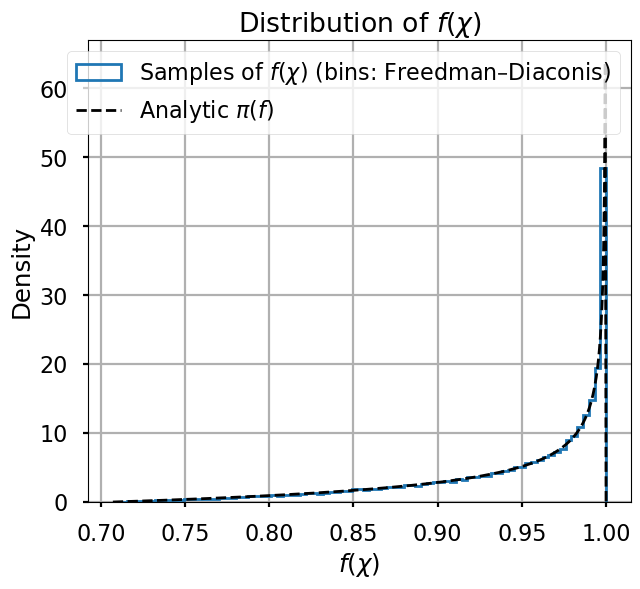

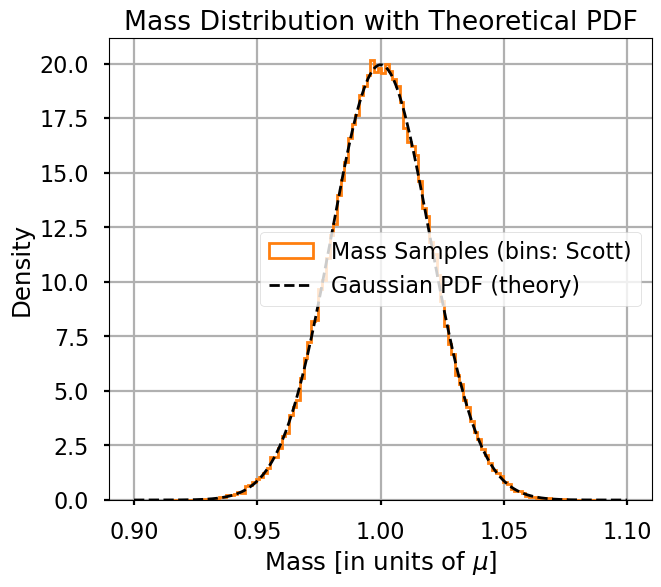

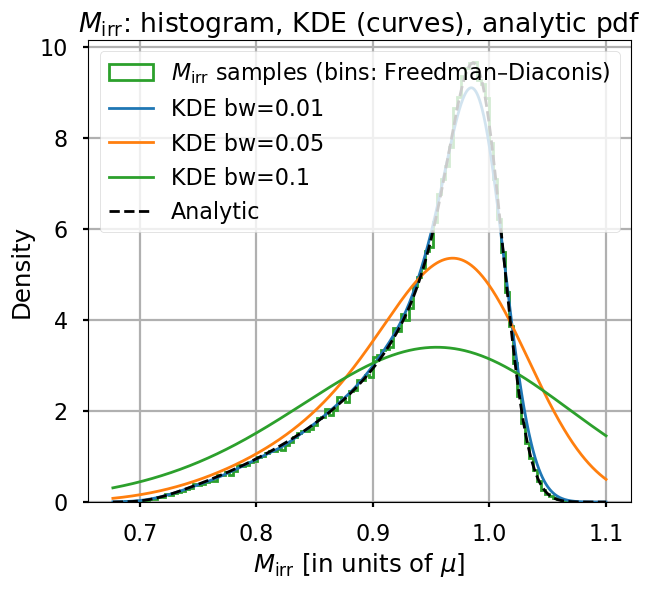

KS tests over sigma: 100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


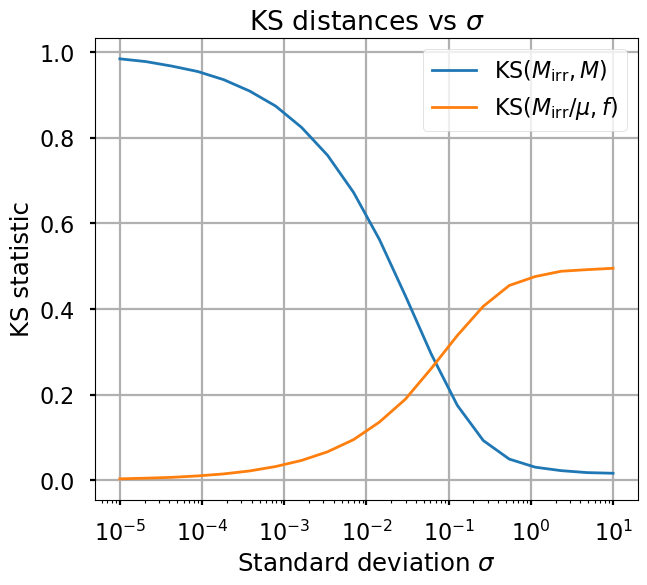

In [15]:
def run_all():
    run_simulation(N=100_000, sigma_mass=0.02)
    ks_analysis_vs_sigma(N=100_000, mu=1.0, scales=np.logspace(-5, 1, 20))
# Execute everything
run_all()